In [1]:
import numpy as np
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from scipy import stats
from scipy.stats import probplot

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

from Wine_Review_Feature_Genetator import FeatureGenetator

### 1. Data loading

data source: https://www.kaggle.com/zynicide/wine-reviews?select=winemag-data_first150k.csv

In [2]:
path ='C:/Users/ASER/'
zip_file = path + '1442_8172_bundle_archive.zip'
archive = zipfile.ZipFile(zip_file, 'r')
data_file = archive.open('winemag-data_first150k.csv')
data = pd.read_csv(data_file)
data = data[data.columns[1:]]
data.index.name = 'id'
data.head(2)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
id,,,,,,,,,,
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez


#### Data with no information on prices is removed from the data set:

In [3]:
ind = data[data.price.isnull()].index
data = data.drop(ind, axis=0)
print(f'data.shape = {data.shape}')

data.shape = (137235, 10)


In [4]:
X = data.drop('price', axis=1)
y = data[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}')

X_train.shape = (102926, 9), y_train.shape = (102926, 1)
X_test.shape = (34309, 9), y_test.shape = (34309, 1)


### 2. Feature engineering

The new variables are generated by FeatureGenetator (Wine_Review_Feature_Genetator.py).
FeatureGenetator performs target encoding of cathegorical variables country, designation, province, region_1, region_2, variety and winery and generates new variables with median prices of each level: 
* MedPriceByCountry, 
* MedPriceByDesignation, 
* MedPriceByProvince, 
* MedPriceByRegion, 
* MedPriceByVariety, 
* MedPriceByWinery.

5 of them (excluding MedPriceByDesignation) were used in principal component analysis to generate 3 new composit variables:
* pca_composit_1, 
* pca_composit_2, 
* pca_composit_3.

3 of them (MedPriceByRegion, MedPriceByVariety, MedPriceByWinery) were clustered and split into binary variables: Cluster_1 and Cluster_2.

Variable points is split into 5 groups and new cathegorical variable points_group is generated.

Cathegorical variable points_group were used to generate binary variables PG_1, PG_2, PG_3, PG_4, PG_5

In [5]:
features = FeatureGenetator()
features.fit(X_train, y_train)

X_train = features.transform(X_train)
X_test = features.transform(X_test)

In [6]:
X_train.columns

Index(['country', 'description', 'designation', 'points', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'MedPriceByCountry',
       'MedPriceByDesignation', 'MedPriceByProvince', 'MedPriceByRegion',
       'MedPriceByVariety', 'MedPriceByWinery', 'points_group', 'PG_1', 'PG_2',
       'PG_3', 'PG_4', 'PG_5', 'Cluster_1', 'Cluster_2', 'pca_composit_1',
       'pca_composit_2', 'pca_composit_3'],
      dtype='object')

In [7]:
features_to_use = ['points', 
                   'MedPriceByCountry','MedPriceByDesignation', 'MedPriceByProvince', 
                   'MedPriceByRegion','MedPriceByVariety', 'MedPriceByWinery',                   
                   'PG_2', 'PG_3', 'PG_4',
                   'Cluster_1',
                   'pca_composit_1','pca_composit_2', 'pca_composit_3']

X_train = X_train[features_to_use]
X_test = X_test[features_to_use]

### 3. Models
#### 3.1. LGBMRegressor

In [8]:
model = LGBMRegressor(max_depth=30, 
                             min_samples_leaf=30,
                             n_estimators=3000, 
                             random_state=42)

cv_score = cross_val_score(model, X_train, np.log(y_train.price), 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.682 +- 0.004

R2: 0.682 +- 0.004


#### Training the model on complete train set:

In [9]:
model.fit(X_train, np.log(y_train))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=30,
              min_split_gain=0.0, n_estimators=3000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

#### Feature_importances

In [10]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model.feature_importances_ / model.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
0,points,0.204056
12,pca_composit_2,0.133233
13,pca_composit_3,0.127389
11,pca_composit_1,0.126567
4,MedPriceByRegion,0.086244
2,MedPriceByDesignation,0.074233
5,MedPriceByVariety,0.073378
6,MedPriceByWinery,0.059356
3,MedPriceByProvince,0.057856
1,MedPriceByCountry,0.024856


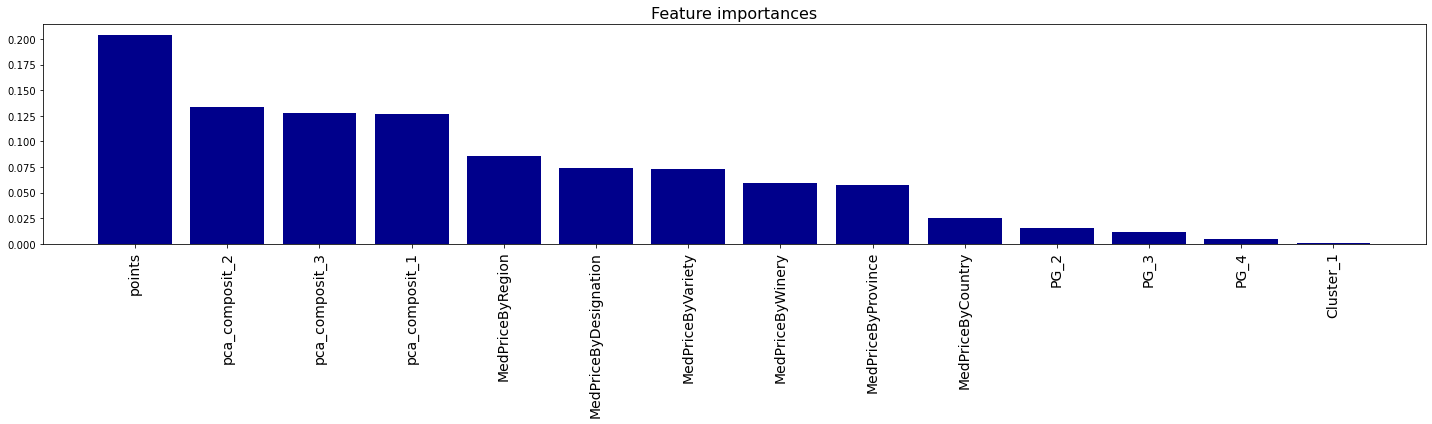

In [11]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X_train)

#### 3.2 RandomForestRegressor

In [12]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=40,  
                                 min_samples_leaf=30, 
                                 random_state=42,
                                
                                n_estimators=500  
                                )
cv_score = cross_val_score(rf_model, X_train.fillna(0), np.log(y_train), 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.682 +- 0.004 - LGBMRegressor

R2: 0.638 +- 0.004


#### 3.3. VotingRegressor

In [13]:
v_model = VotingRegressor([('model', model), ('rf_model', rf_model)])

cv_score = cross_val_score(v_model, X_train.fillna(0), np.log(y_train), 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.682 +- 0.004 - LGBMRegressor

R2: 0.673 +- 0.004


#### 3.4 Linear Regression

In [14]:
features_to_use = ['points', 'pca_composit_1', 'pca_composit_2','pca_composit_3',
                   'PG_2', 'PG_3', 'PG_4', 'Cluster_1']

X_train_linear = X_train[features_to_use]
X_test_linear = X_test[features_to_use]

In [15]:
X_train_linear = X_train.fillna(0)
linear_model = LinearRegression(fit_intercept = True, normalize=True)

cv_score = cross_val_score(linear_model, X_train_linear, np.log(y_train.price), 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std)) 

# R2: 0.682 +- 0.004 LGBMRegressor

R2: 0.469 +- 0.006


### 4.Model hyperparameter tuning 
#### 4.1 LGBMRegressor

In [16]:
lgb_model = LGBMRegressor(criterion='mse', 
                            min_samples_leaf=10,
                            random_state=42
                         )

In [17]:
params = {'n_estimators':[1000, 2000, 3000], 
          'max_depth':[15, 30, 40]}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', 
                  cv=KFold(n_splits=4,   
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  
                 )
gs.fit(X_train, np.log(y_train))

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='mse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_samples_leaf=10, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [15, 30, 40

In [18]:
gs.best_params_

{'max_depth': 30, 'n_estimators': 3000}

#### 4.2 RandomForestRegressor

In [19]:
rf_model = RandomForestRegressor(criterion='mse',                                  
                                 min_samples_leaf=30, 
                                 random_state=42 
                                )

In [20]:
params = {'n_estimators':[300, 500, 1000], 
          'max_depth':[30, 40, 50]}

rf_gs = GridSearchCV(rf_model, params, 
                  scoring='r2',  
                  cv=KFold(n_splits=4,   
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  
                 )
rf_gs.fit(X_train.fillna(0), np.log(y_train))

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=30,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbos

In [21]:
rf_gs.best_params_

{'max_depth': 40, 'n_estimators': 500}

### 5. Final results

In [22]:
y_pred = model.predict(X_test)
r2 = r2_score(np.log(y_test).price, y_pred)
print(f'R2 of LGBMRegressor model on out-of-sample dataset for log(y) = {r2}')      
print('R2 on the out-of-sample dataset is very close to the one on the in-sample dataset')

R2 of LGBMRegressor model on out-of-sample dataset for log(y) = 0.6723498653679242
R2 on the out-of-sample dataset is very close to the one on the in-sample dataset


In [23]:
y_pred_final = np.exp(y_pred)